# Import Packages and Construct Bitome

In [2]:
from pathlib import Path
import sys
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns
import shap
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import *

sys.path.append('../../bitome2')
sys.path.append('../')

from bitome.core import Bitome
from bitome.ml import *

sns.set_style('whitegrid')

shap.initjs()

In [3]:
K12_DATA_PATH = Path('../data/bitome2/mg1655')

In [4]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

In [5]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

In [33]:
#precise2 = load_json_model('../data/precise2.json.gz')
precise1k = load_json_model('../data/p1k/p1k.json.gz')

In [31]:
#data_logtpm = pd.read_csv('../data/p1k/log_tpm_qc.csv', index_col=0)
#data_logtpm_norm = pd.read_csv('../data/p1k/log_tpm_norm_qc.csv', index_col=0)

In [1]:
#Set up X and log_tpm for plotting purposes
#precise1k.log_tpm = data_logtpm
#precise1k.X = data_logtpm_norm

# Basal Expression

## Setting up ICA data

<AxesSubplot:xlabel='Gene Start', ylabel='Arginine Gene Weight'>

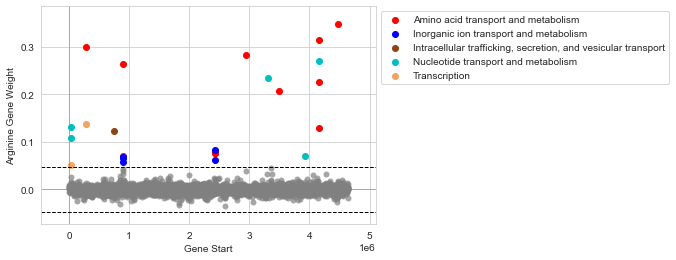

In [123]:
#iM_to_annotate = 'yjjZ'
iM_to_annotate = 'Arginine'
plot_gene_weights(precise1k, iM_to_annotate, adjust_labels=False)

In [124]:
imod_genes = precise1k.view_imodulon(iM_to_annotate)
imod_genes['length'] = imod_genes['end'] - imod_genes['start']
imod_genes.sort_values(by='gene_weight', ascending=False)

,gene_weight,gene_name,synonyms,gene_product,COG,regulator,uniprot,start,end,strand,...,k_eff,schmidt_prot_med,heckmann_prot_med,proteomics,p1k,p1k_ctrl_log_tpm,p1k_median_log_tpm,p1k_mad_log_tpm,in_iM,length
b4254,0.347428,argI,argI,ornithine carbamoyltransferase ArgI,Amino acid transport and metabolism,"RpoD,ArgR,ppGpp,DksA",P04391,4477307,4478311,-,...,True,370.0,882.0,True,True,8.425600,6.933382,1.390987,True,1004
b3958,0.315604,argC,argC,N-acetylglutamylphosphate reductase,Amino acid transport and metabolism,"RpoD,ArgR,ppGpp",P11446,4155001,4156005,+,...,True,949.5,1065.0,True,True,8.465761,7.556441,1.289683,True,1004
b0273,0.299276,argF,argF,CP4-6 prophage%3B ornithine carbamoyltransfera...,Amino acid transport and metabolism,"RpoD,ArgR,ppGpp",P06960,289301,290305,-,...,True,41.0,381.0,True,True,8.896671,7.565149,1.222332,True,1004
b2818,0.282744,argA,argA,N-acetylglutamate synthase,Amino acid transport and metabolism,"RpoD,ArgR,ppGpp,Lrp",P0A6C5,2949242,2950573,+,...,True,202.0,650.0,True,True,9.119366,7.723328,1.312679,True,1331
b3959,0.270328,argB,argB,acetylglutamate kinase,Nucleotide transport and metabolism,"RpoD,ArgR,ppGpp",P0A6C8,4156013,4156789,+,...,True,3018.0,1314.0,True,True,7.914081,7.427953,1.077385,True,776
b0860,0.263863,artJ,artJ,L-arginine ABC transporter periplasmic binding...,Amino acid transport and metabolism,"RpoD,ArgR",P30860,899844,900575,-,...,True,4351.5,3854.0,True,True,9.950698,8.929569,1.205336,True,731
b3172,0.233858,argG,argG,argininosuccinate synthetase,Nucleotide transport and metabolism,"RpoD,YcjW,ArgR,Crp",P0A6E4,3318637,3319980,+,...,True,3584.0,7249.0,True,True,9.762429,8.793899,1.254664,True,1343
b3960,0.225718,argH,argH,argininosuccinate lyase,Amino acid transport and metabolism,"RpoD,YidZ,ArgR,ppGpp",P11447,4156850,4158223,+,...,True,1372.0,1576.0,True,True,8.193179,7.534349,1.084937,True,1373
b3359,0.207970,argD,argD;dapC;dtu,N-acetylornithine aminotransferase/N-succinyld...,Amino acid transport and metabolism,"RpoD,PhoP,ArgR",P18335,3488960,3490180,-,...,True,2295.0,2439.0,True,True,8.266454,7.819727,1.188799,True,1220
b0272,0.137407,xynR,xynR;yagI,CP4-6 prophage%3B DNA-binding transcriptional ...,Transcription,NaN,P77300,288404,289162,-,...,False,NaN,NaN,False,True,6.884970,5.866604,0.809834,True,758


<AxesSubplot:ylabel='Arginine iModulon\nActivity'>

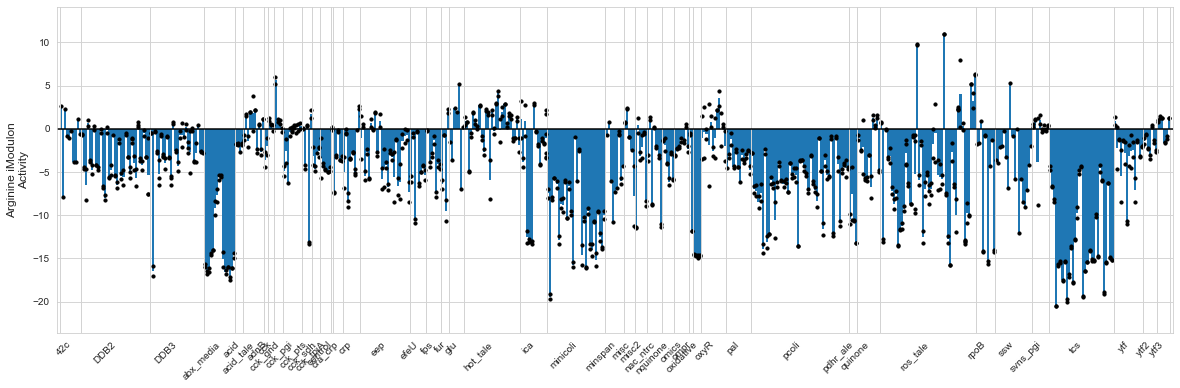

In [125]:
_, ax = plt.subplots(figsize=(20, 6))
plot_activities(precise1k,iM_to_annotate, ax=ax)

## Case studies

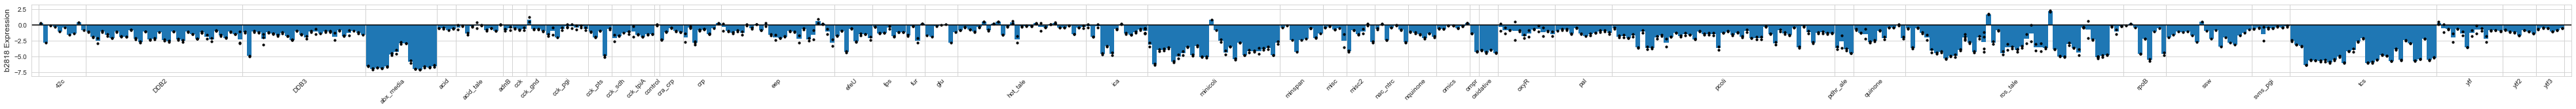

In [38]:
#Plot normalized expression for a gene
gene_cur = 'b2818' #argA
plot_expression(precise1k,gene_cur);

<AxesSubplot:>

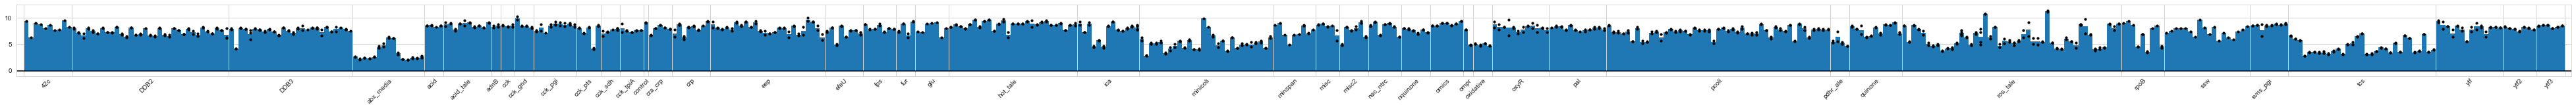

In [104]:
#Plot absolute expression of the gene (log_tpm)
expr_cur = precise1k.log_tpm.loc[gene_cur]
expr_cur_norm = precise1k.X.loc[gene_cur]
barplot(values = expr_cur,sample_table = precise1k.sample_table)

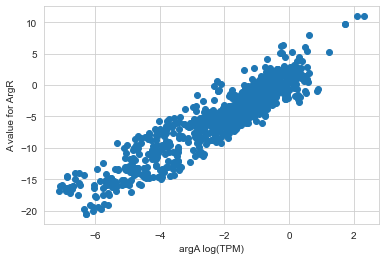

In [105]:
#Correlate expression of argA with argR activity
im_cur = 'Arginine'
A_vals_cur = precise1k.A.loc[im_cur]
plt.scatter(expr_cur_norm,A_vals_cur)
ax = plt.subplot()
ax.set_xlabel("argA log(TPM)")
ax.set_ylabel("A value for ArgR")
plt.show()

In [103]:
precise1k.X.head()

,p1k_00001,p1k_00002,p1k_00003,p1k_00004,p1k_00005,p1k_00006,p1k_00007,p1k_00008,p1k_00009,p1k_00010,...,p1k_01046,p1k_01047,p1k_01048,p1k_01049,p1k_01050,p1k_01051,p1k_01052,p1k_01053,p1k_01054,p1k_01055
b0002,-0.053993,0.053993,0.879043,1.089600,0.182453,-0.078873,-0.837092,-0.502703,0.421312,0.412354,...,-0.868029,-2.012060,-1.862453,-1.950586,-1.642161,-1.666869,-0.639387,-1.552748,-1.892598,-1.831359
b0003,-0.061973,0.061973,1.063330,1.477889,0.392573,0.234671,-0.763015,-0.120989,0.546181,0.520841,...,-1.501588,-2.532496,-2.515189,-2.443481,-2.258418,-2.312108,-1.124294,-2.060022,-2.348524,-2.122772
b0004,-0.036972,0.036972,0.003132,0.356702,-0.096756,-0.334913,-1.714913,-1.322707,-0.234147,-0.250669,...,-0.691635,-1.692102,-1.608955,-1.723764,-1.376420,-1.251488,-0.529185,-1.577833,-1.383521,-1.527079
b0005,-0.104967,0.104967,-1.118145,-1.277963,-0.181546,-0.364057,-2.121475,-1.994770,-0.386684,-0.634659,...,-2.925632,-4.626965,-4.067417,-2.964371,-3.075562,-3.101967,-2.210546,-3.821019,-4.563928,-2.946659
b0006,0.042242,-0.042242,-0.123592,-0.107778,-0.173177,-0.089888,-0.208133,-0.003044,-0.034707,-0.027806,...,0.190536,-0.618740,-0.175381,-0.317349,-0.466331,-0.169979,-0.402588,-0.915991,-0.804728,-0.858978


In [102]:
#Calculate the expression change of all genes due to the target iM
M_vals_cur = precise1k.M[im_cur]
M_vals_cur_array = np.array([M_vals_cur.to_numpy()])
A_vals_cur_array = np.array([A_vals_cur.to_numpy()])
corr_expr = np.multiply(M_vals_cur_array.T,A_vals_cur_array)
df_corr = pd.DataFrame(corr_expr, columns = precise1k.X.columns, index= precise1k.X.index)
print(df_corr.head())

       p1k_00001  p1k_00002  p1k_00003  p1k_00004  p1k_00005  p1k_00006  \
b0002  -0.000034   0.000034  -0.001898  -0.002435   0.000511   0.000418   
b0003  -0.000681   0.000681  -0.037622  -0.048270   0.010133   0.008280   
b0004  -0.000926   0.000926  -0.051149  -0.065625   0.013777   0.011257   
b0005  -0.000337   0.000337  -0.018602  -0.023866   0.005010   0.004094   
b0006  -0.001258   0.001258  -0.069458  -0.089115   0.018708   0.015287   

       p1k_00007  p1k_00008  p1k_00009  p1k_00010  ...  p1k_01046  p1k_01047  \
b0002  -0.001589  -0.001350  -0.000168  -0.000155  ...  -0.000201  -0.001307   
b0003  -0.031502  -0.026769  -0.003335  -0.003083  ...  -0.003979  -0.025915   
b0004  -0.042829  -0.036393  -0.004533  -0.004191  ...  -0.005409  -0.035232   
b0005  -0.015576  -0.013235  -0.001649  -0.001524  ...  -0.001967  -0.012813   
b0006  -0.058159  -0.049420  -0.006156  -0.005692  ...  -0.007345  -0.047844   

       p1k_01048  p1k_01049  p1k_01050  p1k_01051  p1k_01052  p1k_01

<AxesSubplot:>

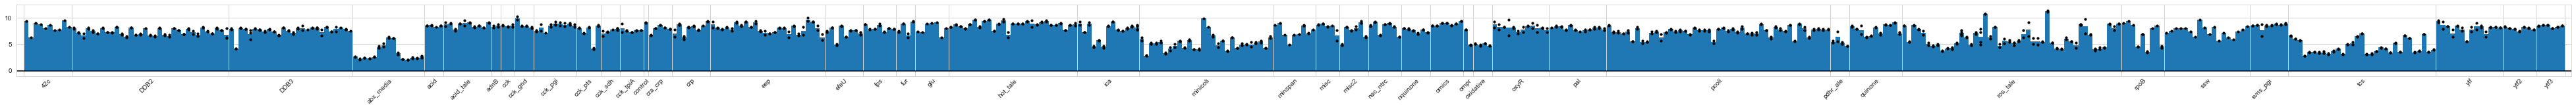

In [115]:
#Calculate basal expression of this gene
expr_norm_adj_all = precise1k.X-df_corr
expr_corr_norm_adj = expr_norm_adj_all.loc[gene_cur]
barplot(values = expr_cur,sample_table = precise1k.sample_table)

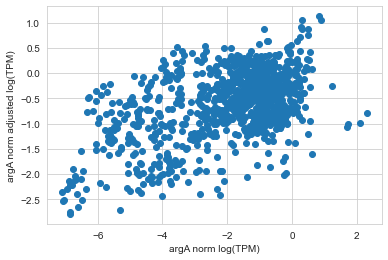

In [116]:
#Compare unadjusted to adjusted
plt.scatter(expr_cur_norm,expr_corr_norm_adj )
ax = plt.subplot()
ax.set_xlabel("argA norm log(TPM)")
ax.set_ylabel("argA norm adjusted log(TPM)")
plt.show()

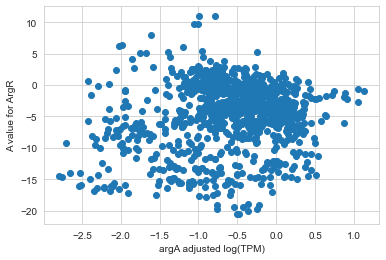

In [117]:
#Correlate adjusted expression of argA with argR activity
plt.scatter(expr_corr_norm_adj,A_vals_cur)
ax = plt.subplot()
ax.set_xlabel("argA adjusted log(TPM)")
ax.set_ylabel("A value for ArgR")
plt.show()

In [118]:
#Compare old and new variation
cov_orig = np.std(expr_cur, ddof=1) / np.mean(expr_cur)
print(cov_orig)
cov_adj = np.std(expr_adj, ddof=1) / np.mean(expr_adj)
print(cov_adj)

0.23983602262826217
b0002       NaN
b0003       NaN
b0004       NaN
b0005       NaN
b0006       NaN
             ..
p1k_01051   NaN
p1k_01052   NaN
p1k_01053   NaN
p1k_01054   NaN
p1k_01055   NaN
Length: 5292, dtype: float64


In [119]:
# Get the reference expression
expr_adj_all = precise1k.X-df_corr

<AxesSubplot:>

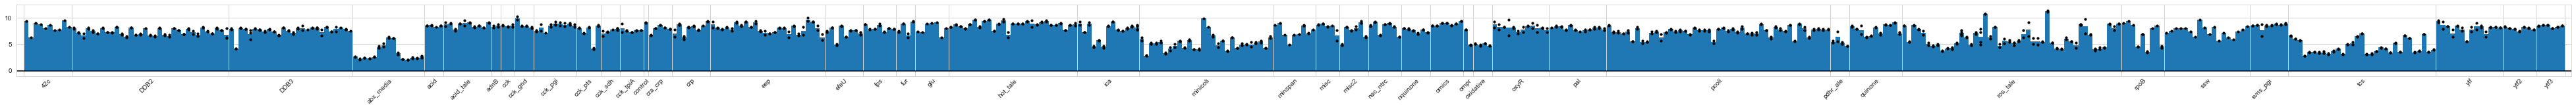

In [120]:
#Before
barplot(values = expr_cur,sample_table = precise1k.sample_table)

<AxesSubplot:>

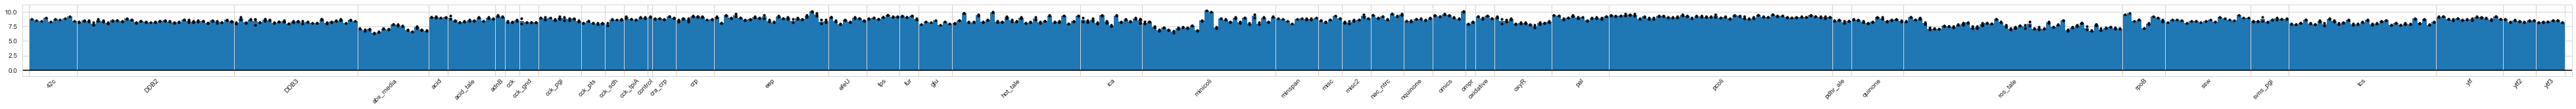

In [113]:
#After
expr_adj_all = precise1k.log_tpm-df_corr
expr_corr_adj = expr_adj_all.loc[gene_cur]
barplot(values = expr_corr_adj,sample_table = precise1k.sample_table)

In [122]:
expr_cur

p1k_00001    9.012179
p1k_00002    9.226552
p1k_00003    7.008773
p1k_00004    6.325181
p1k_00005    9.333854
               ...   
p1k_01051    7.390313
p1k_01052    8.167886
p1k_01053    7.568538
p1k_01054    7.803877
p1k_01055    7.959551
Name: b2818, Length: 1035, dtype: float64

In [121]:
expr_corr_adj

p1k_00001    9.054629
p1k_00002    9.184102
p1k_00003    9.353358
p1k_00004    9.333326
p1k_00005    8.702347
               ...   
p1k_01051    8.303977
p1k_01052    8.049318
p1k_01053    8.375876
p1k_01054    8.558575
p1k_01055    8.692173
Name: b2818, Length: 1035, dtype: float64

In [ ]:
# Repeat on other genes at different TUs regulated by argR

## Adjust the reference point of A vectors to their 0 activity point not just glucose reference

# Alternate MA Calcs

# MA Projections to Explore How Well Decomposition Works

# Quantile normalization

# Multi-reference One-Hot

## Getting promoter sequences

In [6]:
#Grab a set of promoters to experiment with MSA
n_upstream=50
n_downstream=10
#n_upstream=45
#n_downstream=0
indices_promoters = []
seqs_promoters = []
tu_table_tss = mg1655.tu_table[mg1655.tu_table['tss'].notna()]
for tu_row in tu_table_tss.itertuples():
    indices_promoters.append(tu_row.Index)
    if tu_row.strand == 1:
        left, right = tu_row.tss - n_upstream, tu_row.tss + n_downstream
    else:
        left, right = tu_row.tss - n_downstream, tu_row.tss + n_upstream
    seqs_promoters.append(mg1655.get_sequence(left, right, tu_row.strand))
    #one_hot_row = self.one_hot_encode_sequence(left, right, tu_row.strand)
    #one_hot_rows.append(one_hot_row)

In [7]:
seqs_promoters[0:10]

[Seq('AACCCTGCAATCTACATTTACAGCGCAAACATTACTTATTATTAACATATAAAT...AAT'),
 Seq('CGTTTATGCACTTTTATCACTGGCTGGCACGAACCCTGCAATCTACATTTACAG...AAC'),
 Seq('ATGCACTTTTATCACTGGCTGGCACGAACCCTGCAATCTACATTTACAGCGCAA...TAC'),
 Seq('CTATATATTGTGTGGTTGAATCTTTTTTCAACTACATCTAGTATCTCTGTATCA...AGA'),
 Seq('TTTTACACCCCCTGACGCATGTTTGCAGCCTGAATCGTAAACTCTCTATCGTTG...GCG'),
 Seq('GCTTGTAAGCGGCGCCACCAAAATCATCGTGAAATGATATCCTTCGTCATTCGT...TTT'),
 Seq('CGACAGACGGCGACTTTTATAGAACAGGCAAAAGTTCTACAAGAACCCCCTTTG...TAA'),
 Seq('AAAATCTACCTATCTCTTTGATTTTCAAATTATTCGATGTATACAAGCCTATAT...AAC'),
 Seq('TAGCGAAAGTGTGGATGGTAAAAATCTCATTTACACGCTAGTATCGGCATAACC...AAC'),
 Seq('AACGTGATAGCCGTCAAACAAATTGGCACTGAATTATTTTACTCTGTGTAATAA...AGG')]

### Explore -10 and -35 boxes

In [57]:
mg1655.tu_table.head()

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,
ECK120008913,astCADBE,-1.0,1832013.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0,1825955.0,1832013.0
ECK120008914,astCADBE,-1.0,1832044.0,Sigma54,1832054.0,1832058.0,1832065.0,1832070.0,1825955.0,1832044.0
ECK120008915,astCADBE,-1.0,1832039.0,Sigma38,1832046.0,1832056.0,1832070.0,1832075.0,1825955.0,1832039.0
ECK120008916,nrdHIEF,1.0,2800656.0,Sigma70,2800644.0,2800649.0,2800621.0,2800626.0,2800656.0,2804461.0
ECK120008917,cpxPQ,1.0,4105785.0,Sigma70,4105772.0,4105777.0,4105746.0,4105751.0,4105785.0,4106379.0


In [ ]:
# Filter to only sigma 70
sigma_cur = "Sigma70"
tu_sigma70 = mg1655.tu_table[mg1655.tu_table['sigma_factor']==sigma_cur]

# Get the length of -10 and -35boxes
lens_m10 = tu_sigma70['box_10_right']-tu_sigma70['box_10_left']+1
print(lens_m10[lens_m10<6])
print(lens_m10[lens_m10>6])

lens_m35 = tu_sigma70['box_35_right']-tu_sigma70['box_35_left']+1
print(lens_m35[lens_m35<6])
print(lens_m35[lens_m35>6])

In [71]:
lens_spacer = pd.DataFrame(columns=['spacer_len'],index= tu_sigma70.index)

lens_pos = tu_sigma70[tu_sigma70['strand']==1]['box_10_left']-tu_sigma70[tu_sigma70['strand']==1]['box_35_right']-1
lens_pos.head()

locus_tag
ECK120008916    17.0
ECK120008917    20.0
ECK120008918    19.0
ECK120008919    16.0
ECK120008924     NaN
dtype: float64

In [72]:
lens_neg = tu_sigma70[tu_sigma70['strand']==-1]['box_35_left']-tu_sigma70[tu_sigma70['strand']==-1]['box_10_right']-1
lens_neg.head()

locus_tag
ECK120008913    19.0
ECK120008925     NaN
ECK120008933    16.0
ECK120008937    16.0
ECK120008940    17.0
dtype: float64

In [59]:
#Spot check on the first negative and positive  promoter
#ECK120008913, should be length 19
#TSS to back of -35
mg1655.get_sequence(1832013, 1832052, -1)

Seq('CTACATTTACAGCGCAAACATTACTTATTATTAACATATA')

In [60]:
#-10 box
mg1655.get_sequence(1832022, 1832027, -1)

Seq('TATTAT')

In [62]:
#-35 box
mg1655.get_sequence(1832047, 1832052, -1)

Seq('CTACAT')

In [64]:
#Spacer
spacer_l = 1832027+1
spacer_r = 1832047-1
mg1655.get_sequence(spacer_l, spacer_r, -1)

Seq('TTACAGCGCAAACATTACT')

In [67]:
#ECK120008916, should be length 17
#TSS to back of -35
mg1655.get_sequence(2800621, 2800656, 1)

Seq('TTGAATCTTTTTTCAACTACATCTAGTATCTCTGTA')

In [68]:
#-10 box
mg1655.get_sequence(2800644, 2800649, 1)

Seq('TAGTAT')

In [69]:
#-35 box
mg1655.get_sequence(2800621, 2800626, 1)

Seq('TTGAAT')

In [70]:
#Spacer
spacer_l = 2800626+1
spacer_r = 2800644-1
mg1655.get_sequence(spacer_l, spacer_r, 1)

Seq('CTTTTTTCAACTACATC')

In [ ]:
# Score based on -10 PSSM to find the ideal reference start location for the -10 box

### Gap fill missing m35 boxes

In [ ]:
#Investigate why some promoters don't have spacers
mg1655.tu_table.loc['ECK120008924']

In [ ]:
# tss_loc: select the TU to the corresponding genes with the highest sigma70 score
    
def loc_find(gene_tag, motif_data):
    temp = motif_data[motif_data["ID"]== gene_tag] #look at the specified gene_tag only
    
    tss_loc = temp[abs(temp.Sigma70_Prib_score) == abs(temp.Sigma70_Prib_score).max()]["tss_loc"].values           #absolute loc
    m10 = temp[abs(temp.Sigma70_Prib_score) == abs(temp.Sigma70_Prib_score).max()]["Sigma70_Prib_Start"].values    #relative dist (to TSS)
    m35 = temp[abs(temp.Sigma70_m35_score) == abs(temp.Sigma70_m35_score).max()]["Sigma70_m35_Start"].values[0]    #relative dist (to TSS)
    
    #tf loc: select the TF of the corresponding genes with highest scores in all TF
    gene_tfscore = temp.loc[:, temp.columns.str.contains(" score")]
    tf_max = gene_tfscore.idxmax(axis=1)
    a = [(temp.loc[i][tf], i) for i, tf in zip(temp.index, tf_max)]
    tf_max_index = max(a, key=lambda item:item[0])[1]
    tf_loc = temp.loc[tf_max_index][tf_max[tf_max_index][: -6] + (" distToTSS")]                                   #relative dist (tf-tss)
    tf_name = tf_max[tf_max_index][: -6]
    
    # convert to absolute location
    tf_loc_abs = tss_loc + tf_loc
    m10_abs = tss_loc + m10
    m35_abs = tss_loc + m35
    all_loc = {"m35_s70_loc":m35_abs, "m10_s70_loc": m10_abs, "tss_s70_loc":tss_loc, tf_name + "_loc": tf_loc_abs}
    df_noavg = pd.DataFrame(all_loc)
    
    return df_noavg

### Write to file if desired

In [ ]:
#Write to file
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

filename_promoters = "seqs_promoters.fasta"

with open(filename_promoters, "w") as output_handle:
    curInd = 0
    for cur_seq in seqs_promoters:
        cur_record = SeqRecord(
            cur_seq,
            id = str(curInd),
            description = 'Gene' + str(curInd)
        )
        curInd = curInd + 1
        SeqIO.write(cur_record, output_handle, "fasta")

## One-Hot on Multi-reference sequences

In [ ]:
def one_hot_encode_tu_promoters_multiref(self, local_align: bool = False,
                                    n_upstream: int = 50, n_downstream: int = 10,
                                    tss_radius: int = 3, box_10_radius: int = 6,
                                    box_35_radius: int = 6, shift_odd_len_upstream: bool = True
                                    ) -> pd.DataFrame:
        """
        High-level utility function to prepare a data matrix with all TUs (tu_table must be set)
        converted into one-hot sequences. Uses one_hot_encode_sequence under the hood.

        :param bool local_align: indicates if the one-hot encoding should include local regions
            centered around the specific annotated locations of key promoter features: TSS (CRE),
            -10 box, -35 box
        :param int n_upstream: the number of bases upstream from a TSS to include; only used if
            local_align is False; defaults to 50
        :param int n_downstream: the number of bases downstream from a TSS to include; only used if
            local_align is False, defaults to 10
        :param int tss_radius: the number of base pairs up and downstream of the TSS to one-hot
            encode (NOTE: this parameter is in ONE direction, so the final range will be double the
            size of this parameter, plus the TSS itself); only used if local_align is True
        :param int box_10_radius: the number of base pairs up and downstream of the center of the
            -10 box to one-hot encode; this box is typically a hexamer, so the center point will be
            between the 2 central nucleotides; if a box annotation has odd length, it will be
            shifted to ensure alignment with the even-length boxes. The direction of this shift can
            be controlled with shift_odd_len_upstream. Only used if local_align is True
        :param int box_35_radius: the number of base pairs up and downstream of the center of the
            -35 box to one-hot encode; this box is typically a hexamer, so the center point will be
            between the 2 central nucleotides; if a box annotation has odd length, it will be
            shifted to ensure alignment with the even-length boxes. The direction of this shift can
            be controlled with shift_odd_len_upstream. Only used if local_align is True
        :param bool shift_odd_len_upstream: in order to align odd length promoter boxes, indicates
            if they should be shifted 1 bp upstream (i.e. their "center" is 0.5 bp DOWNSTREAM of the
            central base pair) or 1 bp downstream (i.e. their "center" is 0.5 bp UPSTREAM of the
            central base pair); only used if local_align is True
        :return pd.DataFrame one_hot_tu_df: a DataFrame containing rows with one-hot-encoded TSS
            promoter sequences for all TUs with known TSS
        """

        if self.tu_table.empty:
            raise ValueError('No TU table available.')

        # create a utility that will help us rename one-hot row indices from one_hot_encode_sequence
        def reindex_one_hot(old_names, offset, prefix=''):
            new_names = []
            for old_name in old_names:
                ind, base = old_name.split('_')
                new_ind = int(ind) - offset
                new_name = f'{prefix}{new_ind}_{base}'
                new_names.append(new_name)
            return new_names

        #if local_align:
        one_hot_index = []
        one_hot_rows = []
        tu_table_local_align = self.tu_table[
            (self.tu_table['tss'].notna()) &
            (self.tu_table['box_10_left'].notna()) &
            (self.tu_table['box_35_left'].notna())
        ]
        for tu_row in tu_table_local_align.itertuples():

            tss_l, tss_r = tu_row.tss - tss_radius, tu_row.tss + tss_radius

            # define a quick utility to appropriately align the (typically) hexamer boxes
            def get_box_mid(box_l, box_r, strand):
                box_mid = location_to_point(box_l, box_r, strand, 'midpoint')
                # adjust the midpoint if the box has an odd length
                if (box_r - box_l) % 2 == 1:
                    if shift_odd_len_upstream:
                        box_mid = box_mid + 0.5 * strand
                    else:
                        box_mid = box_mid - 0.5 * strand
                return box_mid

            # ceiling/floor handles the case of even length
            b10_mid = get_box_mid(tu_row.box_10_left, tu_row.box_10_right, tu_row.strand)
            b10_l, b10_r = np.ceil(b10_mid - box_10_radius), np.floor(b10_mid + box_10_radius)
            b35_mid = get_box_mid(tu_row.box_35_left, tu_row.box_35_right, tu_row.strand)
            b35_l, b35_r = np.ceil(b35_mid - box_35_radius), np.floor(b35_mid + box_35_radius)

            tss_oh = self.one_hot_encode_sequence(tss_l, tss_r, tu_row.strand)
            tss_oh.index = reindex_one_hot(tss_oh.index, tss_radius, prefix='tss_')
            box_10_oh = self.one_hot_encode_sequence(b10_l, b10_r, tu_row.strand)
            box_10_oh.index = reindex_one_hot(box_10_oh.index, box_10_radius, prefix='-10_')
            box_35_oh = self.one_hot_encode_sequence(b35_l, b35_r, tu_row.strand)
            box_35_oh.index = reindex_one_hot(box_35_oh.index, box_35_radius, prefix='-35_')
            full_oh_row = pd.concat([tss_oh, box_10_oh, box_35_oh])

            one_hot_index.append(tu_row.Index)
            one_hot_rows.append(full_oh_row)

        one_hot_tu_df = pd.DataFrame(one_hot_rows, index=one_hot_index)

        '''else:
            one_hot_index = []
            one_hot_rows = []
            tu_table_tss = self.tu_table[self.tu_table['tss'].notna()]
            for tu_row in tu_table_tss.itertuples():
                one_hot_index.append(tu_row.Index)
                if tu_row.strand == 1:
                    left, right = tu_row.tss - n_upstream, tu_row.tss + n_downstream
                else:
                    left, right = tu_row.tss - n_downstream, tu_row.tss + n_upstream
                one_hot_row = self.one_hot_encode_sequence(left, right, tu_row.strand)
                one_hot_rows.append(one_hot_row)

            one_hot_tu_df = pd.DataFrame(one_hot_rows, index=one_hot_index)

            # adjust the column names to reflect the locations relative to the TSS
            one_hot_tu_df.columns = reindex_one_hot(one_hot_tu_df.columns, n_upstream) '''
            

        # adjust the column names to reflect the locations relative to the TSS
        one_hot_tu_df.columns = reindex_one_hot(one_hot_tu_df.columns, n_upstream)
        
        return one_hot_tu_df

In [ ]:
#one_hot_tus = mg1655.one_hot_encode_tu_promoters_msa(n_upstream=50, n_downstream=10)
#one_hot_tus.head()